# Ilford HP5+ 400 v2

Notebook for extracting film pigment and experimenting with layers to get the right balancing.

## Film Pigment

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski

### Load film image & preprocess

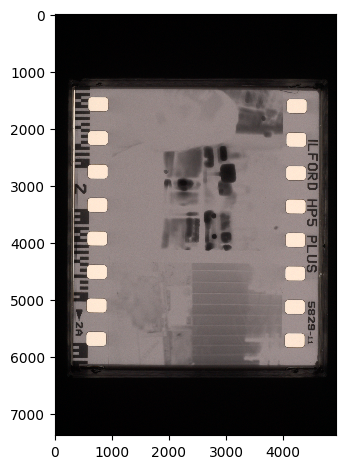

In [3]:
import rawpy

with rawpy.imread("Films/raw/HP5+_400.NEF") as raw:
    image = ski.util.img_as_float32(raw.postprocess().copy())

ski.io.imshow(image)

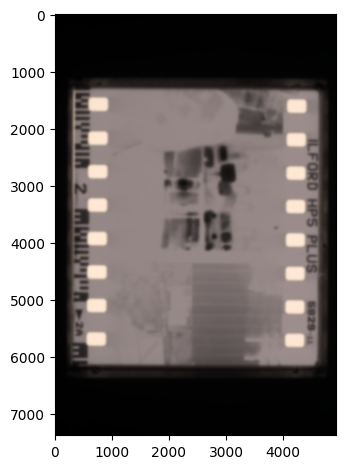

In [4]:
blurred = ski.filters.gaussian(image, sigma=(20, 20), channel_axis=-1)
ski.io.imshow(blurred)

### Obtain colour distribution

In [5]:
distribution, edges = np.histogramdd(blurred.reshape(-1, 3), bins=256, range=[(0,1), (0,1), (0, 1)],)

In [6]:
LIMIT_COLOURS = 80

sorted_count = np.sort(distribution, axis=None)[-LIMIT_COLOURS:]
indices = np.argsort(distribution, axis=None)[-LIMIT_COLOURS:]

sorted_colours = np.array(np.unravel_index(indices, shape=distribution.shape)).T
by_intensity = np.linalg.norm(sorted_colours, axis=1).argsort()

sorted_count_by_intensity = sorted_count[by_intensity]
sorted_colours_by_intensity = sorted_colours[by_intensity]

### Select `white` and `emulsion` colours

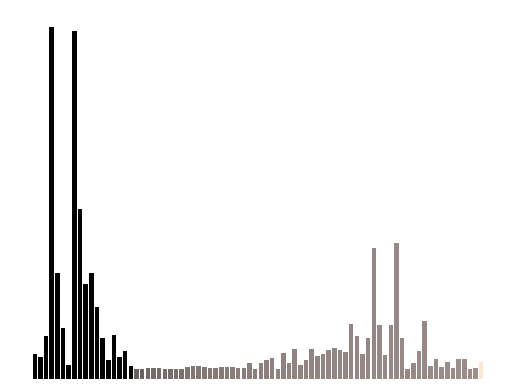

In [7]:
plt.bar(np.arange(LIMIT_COLOURS) + 1, sorted_count_by_intensity[-LIMIT_COLOURS:], color=sorted_colours_by_intensity[-LIMIT_COLOURS:] / 255)
plt.axis("off")
plt.show()

In [8]:
white = sorted_colours_by_intensity[-1]
emulsion = sorted_colours_by_intensity[-2]

print(f"White value: {tuple(white.tolist())}")
print(f"Emulsion value: {tuple(emulsion.tolist())}")

White value: (255, 233, 213)
Emulsion value: (157, 143, 142)


### Preprocess `emulsion` to get pigment

In [9]:
from nevernegative.layers.balancing.temperature import Temperature

pigment = (emulsion * 255 / white).astype(np.uint8)
temperature = Temperature.infer_temperature(white)

print(f"Pigment value: {tuple(pigment.tolist())}")
print(f"Estimated white temperature: {temperature:.0f}K.")


Pigment value: (157, 156, 170)
Estimated white temperature: 5280K.


(np.float64(-0.5), np.float64(4923.5), np.float64(7377.5), np.float64(-0.5))

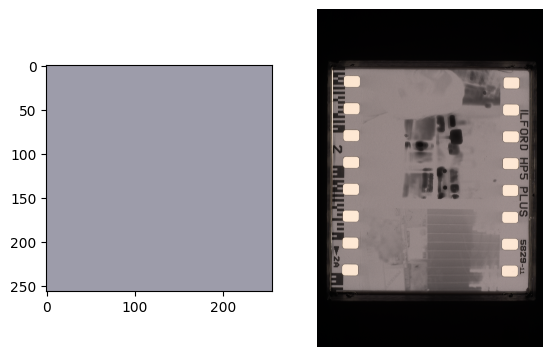

In [10]:
pigment_image = np.empty((256, 256, 3), dtype=np.uint8)
pigment_image[:, :] = pigment

figure, axes = plt.subplots(1, 2)
[pigment_axis, image_axis] = axes.ravel()

pigment_axis.imshow(pigment_image)
image_axis.imshow(image)

plt.axis("off")

## Layers

In [11]:
from pathlib import Path
from nevernegative.layers.utils.resize import Resize
from nevernegative.scanner.simple import SimpleScanner
import matplotlib.pyplot as plt
import torch

In [12]:
images_path = Path("/Users/louismanestar/Library/CloudStorage/GoogleDrive-louis.manestar@gmail.com/My Drive/Film Photos/24-12-01 Christmas Home Nikon HP5+/scans/v1")
# images_path = Path("/Users/louismanestar/Documents/Projects/Film Scanner/nevernegative/images/Ilfocolor")
output_path = Path("/Users/louismanestar/Library/CloudStorage/GoogleDrive-louis.manestar@gmail.com/My Drive/Film Photos/24-12-01 Christmas Home Nikon HP5+/nevernegative/v1")
glob = "*.NEF"

### Remove pigment

In [13]:
from nevernegative.layers.balancing.brightness import Brightness
from nevernegative.layers.balancing.grey import Grey
from nevernegative.layers.balancing.pigment import RemoveEmulsionPigment
from nevernegative.layers.balancing.temperature import Temperature
from nevernegative.layers.balancing.invert import Invert
from nevernegative.layers.utils.clip import Clip

layers = [
    Temperature(temperature=6000),
    RemoveEmulsionPigment(pigment=(157, 156, 170)),
    Invert(),
    Grey(channel=2),
    Brightness(1.2),
    # Contrast(1.2),
    Clip(),
]

### Testing Layers

### Film Image

In [ ]:
scanner = SimpleScanner([Resize(height=400), *layers], device="mps")

processed = scanner.array(
    torch.tensor(image).permute(2, 0, 1).to("mps"),
    plot_path=output_path / "film_image"
)

plt.imshow(processed.permute(1, 2, 0).cpu().numpy())
plt.axis("off")

#### Single Image

(np.float64(-0.5), np.float64(265.5), np.float64(399.5), np.float64(-0.5))

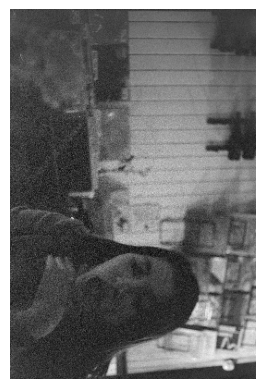

In [15]:
scanner = SimpleScanner([Resize(height=400), *layers], device="mps")

filename = "DSC_2225.NEF"

processed = scanner.file(
    source=images_path / filename,
    destination=output_path / "single_image",
    is_raw=True,
    plot_path="image_location"
)

plt.imshow(processed.permute(1, 2, 0).cpu().numpy(), cmap="gray")
plt.axis("off")

In [16]:
scanner = SimpleScanner(layers, device="mps")

scanner.glob(
    source=(images_path / glob).as_posix(),
    destination=output_path,
    is_raw=True,
)

Proccesing images: 100%|██████████| 38/38 [03:45<00:00,  5.92s/it]
